In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import AttentiveFPAtomFeaturizer
from dgllife.utils import AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset
import dgl
import matplotlib
import matplotlib.cm as cm
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

if torch.cuda.is_available():
    print('use GPU')
    device = 'cuda'
else:
    print('use CPU')
    device = 'cpu'

use CPU


In [35]:
def collate_molgraphs(data):
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
    return smiles, bg, labels, masks

### Load Dataset

In [36]:
atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
n_feats = atom_featurizer.feat_size('hv')
e_feats = bond_featurizer.feat_size('he')

dc_listings = pd.read_csv('../MTATFP/Data/JAK_inhibitor_series.csv')
extest_datasets = MoleculeCSVDataset(dc_listings,
                            smiles_to_graph=smiles_to_bigraph,
                            node_featurizer=atom_featurizer,
                            edge_featurizer= bond_featurizer,
                            smiles_column='SMILES',
                            cache_file_path='../MTATFP/Data/jak_extest.bin',
                            task_names=['pIC50_JAK1','pIC50_JAK2','pIC50_JAK3','pIC50_TYK2'],
                            load=True,init_mask=True
                            )

extest_loader = DataLoader(extest_datasets,batch_size=256,shuffle=True,collate_fn=collate_molgraphs)
print('ExTest sets: ',len(extest_datasets))

Loading previously saved dgl graphs...
ExTest sets:  38


###  Load Model

In [37]:
fn = '../MTATFP/Model/MTATFP_jak.pt'
model = model_zoo.AttentiveFPPredictor(node_feat_size=n_feats,
                                   edge_feat_size=e_feats,
                                   num_layers=2,
                                   num_timesteps=1,
                                   graph_feat_size=300,
                                   n_tasks=4,
                                    )
model.load_state_dict(torch.load(fn,map_location=torch.device('cpu')))

<All keys matched successfully>

### Draw Molecules 

In [40]:
def draw(mol_id, dataset, timestep):
    smiles, g, label, _ = dataset[mol_id]
    g = dgl.batch([g])
    atom_feats, bond_feats = g.ndata.pop('hv'), g.edata.pop('he')
    preds, atom_weights1 = model(g, atom_feats, bond_feats, get_node_weight=True)
    assert timestep < len(atom_weights1)
    atom_weights1 = atom_weights1[timestep]
    min_value = torch.min(atom_weights1)
    max_value = torch.max(atom_weights1)
    atom_weights = (atom_weights1 - min_value) / (max_value - min_value)
    c=atom_weights.detach().cpu().numpy().flatten().tolist()
    norm = matplotlib.colors.Normalize(vmin=0,vmax=(sum(c)/len(c)))
    cmap = cm.get_cmap('summer_r')
    plt_colors = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) for i in range(g.number_of_nodes())}
    plt_colors._A = [] 
    cb = plt.colorbar(plt_colors) 
    cb.set_ticks([]) 
    

    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(300,300)
    
    drawer.SetFontSize(1)
    op = drawer.drawOptions().addAtomIndices=True
    
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol,highlightAtoms=range(g.number_of_nodes()),highlightBonds=[],
    highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    display(SVG(svg))
    return smiles,label,preds,atom_weights

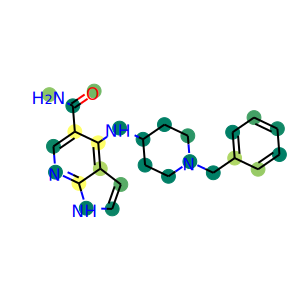

('NC(=O)c1cnc2[nH]ccc2c1NC1CCN(Cc2ccccc2)CC1',
 tensor([-1.9445, -1.9243, -1.3617, -2.0434]),
 tensor([[-1.8679, -1.7290, -1.4729, -2.0613]], grad_fn=<AddmmBackward>),
 tensor([[0.2043],
         [0.4666],
         [0.2543],
         [0.0000],
         [0.4353],
         [1.0000],
         [0.0000],
         [0.9613],
         [0.4381],
         [0.3004],
         [0.1415],
         [0.0021],
         [0.8551],
         [1.0000],
         [0.6369],
         [0.3787],
         [0.7194],
         [0.7194],
         [0.1415],
         [0.4825],
         [0.3340],
         [0.4243],
         [0.7591],
         [0.1844],
         [0.5022],
         [0.5209]], grad_fn=<DivBackward0>))

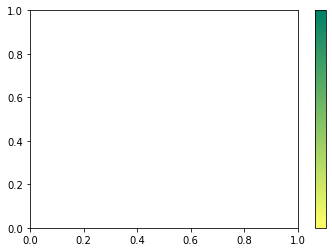

In [41]:
draw(0,extest_datasets, 0)